# What is node classification?

Node classification is a supervised machine learning (ML) approach whereby existing nodes with known classes can be used to train a model that will learn the classes for nodes where they are unknown. In order to achieve this, the data must be split into two parts — a training graph and a testing graph — prior to predicting the classes for the unknown nodes. The training process involves splitting the training graph into two parts — a training and validation set — that will be used to fine tune the model through subsequent steps.

Node classification is based on logistic regression. As in any ML model, care must be taken in choosing both the training and test sets as well as how to ensure that the model is not overfitting the data. In the case of the GDS Node Classification algorithm, an L2 norm is used as a penalty.


#### ML with GDS ... continued from https://github.com/AliciaFrame/ML_with_GDS

In [4]:
# Define Neo4j connections
import pandas as pd
from neo4j import GraphDatabase
host = 'neo4j://localhost:7687'
user = 'neo4j'
password = 'letmein'
driver = GraphDatabase.driver(host,auth=(user, password))

In [3]:
def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

## Marvel Universe dataset

In this example we will be using a dataset from the comics and movies associated with the Marvel Universe. This dataset can be found here. It contains 40,616 characters and 65,870 relationships connecting them. Additionally, the characters have numerous properties that can be associated with each node. We will be using this dataset to try and predict, off of a series of characters for training purposes, which characters are X-Men and which are not.

### 1.  Data preparation

We will begin by loading in the data to the database from a series of CSV files available online. This can be done with the following query:


In [4]:
import_queries = """

CALL apoc.schema.assert({Character:['name']},{Comic:['id'], Character:['id'], Event:['id'], Group:['id']});

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/Marvel/heroes.csv" as row
CREATE (c:Character)
SET c += row;

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/Marvel/groups.csv" as row
CREATE (c:Group)
SET c += row;

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/Marvel/events.csv" as row
CREATE (c:Event)
SET c += row;

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/Marvel/comics.csv" as row
CREATE (c:Comic)
SET c += apoc.map.clean(row,[],["null"]);

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/Marvel/heroToComics.csv" as row
MATCH (c:Character{id:row.hero})
MATCH (co:Comic{id:row.comic})
MERGE (c)-[:APPEARED_IN]->(co);

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/Marvel/heroToEvent.csv" as row
MATCH (c:Character{id:row.hero})
MATCH (e:Event{id:row.event})
MERGE (c)-[:PART_OF_EVENT]->(e);

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/Marvel/heroToGroup.csv" as row
MATCH (c:Character{id:row.hero})
MATCH (g:Group{id:row.group})
MERGE (c)-[:PART_OF_GROUP]->(g);

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/Marvel/heroToHero.csv" as row
MATCH (s:Character{id:row.source})
MATCH (t:Character{id:row.target})
CALL apoc.create.relationship(s,row.type, {}, t) YIELD rel
RETURN distinct 'done';

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/Marvel/heroStats.csv" as row
MATCH (s:Character{id:row.hero})
CREATE (s)-[:HAS_STATS]->(stats:Stats)
SET stats += apoc.map.clean(row,['hero'],[]);

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/Marvel/heroFlight.csv" as row
MATCH (s:Character{id:row.hero})
SET s.flight = row.flight;

MATCH (s:Stats)
WITH keys(s) as keys LIMIT 1
MATCH (s:Stats)
UNWIND keys as key
CALL apoc.create.setProperty(s, key, toInteger(s[key]))
YIELD node
RETURN distinct 'done';
"""

## Graph import

In [5]:
with driver.session() as session:
    for statement in import_queries.split(';'):
        try:
            session.run(statement.strip())
        except:
            pass

This query creates a series of nodes and their labels and properties: Comic, Character, Stats along with a variety of edges such as which comics the characters appeared in which comics, who is an enemy of whom, etc. You can see a schema of this graph using CALL db.schema.visualization() here:

<img src="https://neo4j.com/developer/graph-data-science/_images/marvel-schema.png" width=600 height=600 />

### 2. Move character traits to character nodes
We next bring in the character traits from the stats to be node properties. These node properties will eventually be used to build the node classification model via both embeddings as well as the tabular approach.

In [61]:
run_query("""
MATCH (c:Character)-[:HAS_STATS]->(s)
WITH c, s.strength as strength, s.fighting_skills as fighting_skills, s.durability as durability, s.speed as speed, s.intelligence as intelligence, s.energy as energy
SET c.strength=strength,
    c.fighting_skills=fighting_skills,
    c.durability=durability,
    c.speed=speed,
    c.intelligence=intelligence,
    c.energy=energy
RETURN count(c)
""")

,count(c)
0,470


### 3. Create an appeared together relationship
Next, we set up the co-occurance of characters such that we can identify which characters appear with which other characters and how often (which will be used to identify the edge weighting). This is done via:

In [64]:
run_query("""
MATCH (c1:Character)-[:APPEARED_IN]->(c:Comic)<-[:APPEARED_IN]-(c2:Character) 
WITH c1, c2, count(c) as weight
MERGE (c1)-[:APPEARED_WITH{times:weight}]->(c2)
MERGE (c2)-[:APPEARED_WITH{times:weight}]->(c1)
""")

""


### 4. one hot encode group membership <-- I ended up not using this, but useful to know how to 

In [10]:
run_query("""
MATCH (group:Group)
WITH group
   ORDER BY group.name
WITH collect(group) AS groups
MATCH (c:Character)
WITH c, gds.alpha.ml.oneHotEncoding(groups, [(c)-[:PART_OF_GROUP]->(group) | group]) as group_membership
SET c.group_membership=group_membership
""")

""


## Feature Engineering
Once our data is loaded in, it is time to start the process of engineering the features that will be used to populate our mode. For example, we might consider a variety of **centrality** measures of the character to be a feature that would be useful to train with. To obtain this, we first create an in-memory graph as:

### 1. load graph with features

In [12]:
# list graphs already created
run_query("""
CALL gds.graph.list()
""")

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,detailSizeInBytes,nodeProjection,relationshipProjection,nodeQuery,relationshipQuery,nodeCount,relationshipCount,density,creationTime,modificationTime,schema
0,"{'p99': 765, 'min': 0, 'max': 1174, 'mean': 12...",marvel-character-graph,neo4j,6288 KiB,6439616,"{'relationships': {'total': 2704160, 'everythi...",{'Person': {'properties': {'group_membership':...,{'ENEMY_UNDIRECTED': {'orientation': 'UNDIRECT...,None,None,1105,132845,0.108896,2021-03-24T13:12:40.608004000-04:00,2021-03-24T13:12:41.079009000-04:00,"{'relationships': {'ENEMY_UNDIRECTED': {}, 'EN..."


In [13]:
## drop all previous graphs in memory
run_query("""
CALL gds.graph.list()
YIELD graphName AS namedGraph
WITH namedGraph
CALL gds.graph.drop(namedGraph)
YIELD graphName
RETURN graphName;
""")

# run_query("""
# CALL gds.graph.drop('marvel-character-graph')
# """)

,graphName
0,marvel-character-graph


In [14]:
run_query("""
CALL gds.graph.create(
  'marvel-character-graph',
  {
    Person: {
      label: 'Character',
      properties: { 
      strength:{property:'strength',defaultValue:0},
      fighting_skills:{property:'fighting_skills', defaultValue:0},
      durability:{property:'durability', defaultValue:0},
      speed:{property:'speed', defaultValue:0},
      intelligence:{property:'intelligence', defaultValue:0},
      group_membership:{property:'group_membership',defaultValue:[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]}
      }
    }
  }, {
    APPEARS_WITH_UNDIRECTED: {
      type: 'APPEARED_WITH',
      orientation: 'UNDIRECTED',
      aggregation: 'SINGLE',
      properties: ['times']
    },
    APPEARS_WITH_DIRECTED: {
      type: 'APPEARED_WITH',
      orientation: 'NATURAL',
      properties: ['times'],
      aggregation: 'SINGLE'
    },
    ALLY_UNDIRECTED: {
      type: 'ALLY',
      orientation: 'UNDIRECTED',
      aggregation: 'SINGLE'
    },
    ALLY_DIRECTED: {
      type: 'ALLY',
      orientation: 'NATURAL',
      aggregation: 'SINGLE'
    },    
    ENEMY_UNDIRECTED: {
      type: 'ENEMY',
      orientation: 'UNDIRECTED',
      aggregation: 'SINGLE'
    },
    ENEMY_DIRECTED: {
      type: 'ENEMY',
      orientation: 'NATURAL',
      aggregation: 'SINGLE'
    }
   
});
""")

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,{'Person': {'properties': {'group_membership':...,{'ENEMY_UNDIRECTED': {'orientation': 'UNDIRECT...,marvel-character-graph,1105,132845,90


and then we use this graph to calculate the PageRank, Betweenness Centrality, and Hyperlink-Induced Topic Search (HITS) of each node and write those values back to the database:

### 2. run centrality algos to add more features 
### pageRank

In [17]:
run_query("""

// pageRank
CALL gds.pageRank.write('marvel-character-graph',{
     relationshipTypes: ['APPEARS_WITH_DIRECTED'],
     writeProperty: 'appeared_with_pageRank'
});


""")

,writeMillis,nodePropertiesWritten,ranIterations,didConverge,centralityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,67,1105,20,False,"{'p99': 4.413420677185059, 'min': 0.1499996185...",33,0,171,"{'maxIterations': 20, 'writeConcurrency': 4, '..."


In [18]:
run_query("""

// pageRank
CALL gds.pageRank.write('marvel-character-graph',{
     relationshipTypes: ['ALLY_DIRECTED'],
     writeProperty: 'ally_pageRank'
});


""")

,writeMillis,nodePropertiesWritten,ranIterations,didConverge,centralityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,58,1105,19,True,"{'p99': 0.36827564239501953, 'min': 0.14999961...",10,0,73,"{'maxIterations': 20, 'writeConcurrency': 4, '..."


In [19]:
run_query("""

// pageRank
CALL gds.pageRank.write('marvel-character-graph',{
     relationshipTypes: ['ENEMY_DIRECTED'],
     writeProperty: 'enemy_pageRank'
});


""")

,writeMillis,nodePropertiesWritten,ranIterations,didConverge,centralityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,43,1105,16,True,"{'p99': 0.3315916061401367, 'min': 0.149999618...",12,0,1062,"{'maxIterations': 20, 'writeConcurrency': 4, '..."


### betweenness

In [20]:
run_query("""

// betweenness
CALL gds.betweenness.write('marvel-character-graph',{
     relationshipTypes: ['APPEARS_WITH_UNDIRECTED'],
     writeProperty: 'appeared_with_betweenness'
});


""")

,nodePropertiesWritten,writeMillis,centralityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,1105,60,"{'p99': 6057.406249880791, 'min': 0.0, 'max': ...",161,1,409,"{'writeConcurrency': 4, 'writeProperty': 'appe..."


In [93]:
run_query("""

// betweenness
CALL gds.betweenness.write('marvel-character-graph',{
     relationshipTypes: ['ALLY_UNDIRECTED'],
     writeProperty: 'ally_betweenness'
});


""")

,nodePropertiesWritten,writeMillis,centralityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,1105,69,"{'p99': 1849.0078048706055, 'min': 0.0, 'max':...",28,0,10,"{'writeConcurrency': 4, 'writeProperty': 'ally..."


In [21]:
run_query("""
// betweenness
CALL gds.betweenness.write('marvel-character-graph',{
     relationshipTypes: ['ENEMY_UNDIRECTED'],
     writeProperty: 'enemy_betweenness'
});

""")

,nodePropertiesWritten,writeMillis,centralityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,1105,59,"{'p99': 2607.9687480926514, 'min': 0.0, 'max':...",42,0,11,"{'writeConcurrency': 4, 'writeProperty': 'enem..."


### HITS

In [22]:
run_query("""

//HITS
CALL gds.alpha.hits.write('marvel-character-graph',{
     relationshipTypes: ['APPEARS_WITH_DIRECTED'],
     hitsIterations: 50,
     authProperty: 'appeared_with_auth',
     hubProperty: 'appeared_with_hub'
});

""")

,nodePropertiesWritten,ranIterations,didConverge,writeMillis,postProcessingMillis,createMillis,computeMillis,configuration
0,2210,201,False,90,0,9,371,"{'writeConcurrency': 0, 'writeProperty': '', '..."


In [23]:
run_query("""

//HITS
CALL gds.alpha.hits.write('marvel-character-graph',{
     relationshipTypes: ['ALLY_DIRECTED'],
     hitsIterations: 50,
     authProperty: 'appeared_with_auth',
     hubProperty: 'appeared_with_hub'
});

""")

,nodePropertiesWritten,ranIterations,didConverge,writeMillis,postProcessingMillis,createMillis,computeMillis,configuration
0,2210,201,False,38,0,1,26,"{'writeConcurrency': 0, 'writeProperty': '', '..."


In [24]:
run_query("""

//HITS
CALL gds.alpha.hits.write('marvel-character-graph',{
     relationshipTypes: ['ENEMY_DIRECTED'],
     hitsIterations: 50,
     authProperty: 'appeared_with_auth',
     hubProperty: 'appeared_with_hub'
});

""")

,nodePropertiesWritten,ranIterations,didConverge,writeMillis,postProcessingMillis,createMillis,computeMillis,configuration
0,2210,201,False,29,0,1,15,"{'writeConcurrency': 0, 'writeProperty': '', '..."


### 3. mutate the in-memory graph rather than reload

We will also want these values added to the in-memory graph for the sake of calculating graph embeddings in the next step, which is achieved through the .mutate() command:

In [25]:
run_query("""

// pageRank

CALL gds.pageRank.mutate('marvel-character-graph',{
     relationshipTypes: ['APPEARS_WITH_DIRECTED'],
     mutateProperty: 'appeared_with_pageRank'
});

""")

,mutateMillis,nodePropertiesWritten,ranIterations,didConverge,centralityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,0,1105,20,False,"{'p99': 4.413420677185059, 'min': 0.1499996185...",6,0,106,"{'maxIterations': 20, 'sourceNodes': [], 'rela..."


In [26]:
run_query("""

// pageRank

CALL gds.pageRank.mutate('marvel-character-graph',{
     relationshipTypes: ['ALLY_DIRECTED'],
     mutateProperty: 'ally_pageRank'
});
""")

,mutateMillis,nodePropertiesWritten,ranIterations,didConverge,centralityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,0,1105,19,True,"{'p99': 0.36827564239501953, 'min': 0.14999961...",2,0,63,"{'maxIterations': 20, 'sourceNodes': [], 'rela..."


In [27]:
run_query("""

// pageRank

CALL gds.pageRank.mutate('marvel-character-graph',{
     relationshipTypes: ['ENEMY_DIRECTED'],
     mutateProperty: 'enemy_pageRank'
});
""")

,mutateMillis,nodePropertiesWritten,ranIterations,didConverge,centralityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,0,1105,16,True,"{'p99': 0.3315916061401367, 'min': 0.149999618...",2,0,46,"{'maxIterations': 20, 'sourceNodes': [], 'rela..."


In [28]:
run_query("""

// betweenness

CALL gds.betweenness.mutate('marvel-character-graph',{
     relationshipTypes: ['APPEARS_WITH_UNDIRECTED'],
     mutateProperty: 'appeared_with_betweenness'
});
""")

,nodePropertiesWritten,mutateMillis,centralityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,1105,0,"{'p99': 6057.406249880791, 'min': 0.0, 'max': ...",71,0,272,"{'nodeLabels': ['*'], 'sudo': False, 'relation..."


In [29]:
run_query("""

// betweenness

CALL gds.betweenness.mutate('marvel-character-graph',{
     relationshipTypes: ['ALLY_UNDIRECTED'],
     mutateProperty: 'ally_betweenness'
});
""")

,nodePropertiesWritten,mutateMillis,centralityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,1105,0,"{'p99': 1849.0078048706055, 'min': 0.0, 'max':...",35,0,2,"{'nodeLabels': ['*'], 'sudo': False, 'relation..."


In [30]:
run_query("""

// betweenness

CALL gds.betweenness.mutate('marvel-character-graph',{
     relationshipTypes: ['ENEMY_UNDIRECTED'],
     mutateProperty: 'enemy_betweenness'
});
""")

,nodePropertiesWritten,mutateMillis,centralityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,1105,0,"{'p99': 2607.9687480926514, 'min': 0.0, 'max':...",39,0,2,"{'nodeLabels': ['*'], 'sudo': False, 'relation..."


In [31]:
run_query("""

//HITS

CALL gds.alpha.hits.mutate('marvel-character-graph',{
     relationshipTypes: ['APPEARS_WITH_DIRECTED'],
     hitsIterations: 50,
     authProperty: 'appeared_with_auth',
     hubProperty: 'appeared_with_hub'
});
""")

,nodePropertiesWritten,ranIterations,didConverge,mutateMillis,postProcessingMillis,createMillis,computeMillis,configuration
0,2210,201,False,0,0,1,293,"{'writeConcurrency': 0, 'writeProperty': '', '..."


In [32]:
run_query("""

//HITS

CALL gds.alpha.hits.mutate('marvel-character-graph',{
     relationshipTypes: ['ALLY_DIRECTED'],
     hitsIterations: 50,
     authProperty: 'appeared_with_auth',
     hubProperty: 'appeared_with_hub'
});
""")

,nodePropertiesWritten,ranIterations,didConverge,mutateMillis,postProcessingMillis,createMillis,computeMillis,configuration
0,2210,201,False,0,0,1,14,"{'writeConcurrency': 0, 'writeProperty': '', '..."


In [33]:
run_query("""

//HITS

CALL gds.alpha.hits.mutate('marvel-character-graph',{
     relationshipTypes: ['ENEMY_DIRECTED'],
     hitsIterations: 50,
     authProperty: 'appeared_with_auth',
     hubProperty: 'appeared_with_hub'
});
""")

,nodePropertiesWritten,ranIterations,didConverge,mutateMillis,postProcessingMillis,createMillis,computeMillis,configuration
0,2210,201,False,0,0,1,14,"{'writeConcurrency': 0, 'writeProperty': '', '..."


### 4. compute fastRP extended embedding (Fast Random Projection (FastRP) node embedding algorithm)
Lastly, we will use the Fast Random Projection (FastRP) embedding algorithm to create embedding vectors for each node, that will be used in one of our node classifications. Despite the fact that we will only be looking at a subset of this graph, namely X-Men and those who might be X-men or relate to them somehow, but we will compute the embeddings for the whole graph.

#### I'm writing this back because I'm only going to train my model on known characters, but I want the embedding for the full graph

In [ ]:
run_query("""
CALL gds.beta.fastRPExtended.write('marvel-character-graph',{
    relationshipTypes:['APPEARS_WITH_UNDIRECTED'],
    featureProperties: ['strength','fighting_skills','durability','speed','intelligence','appeared_with_pageRank','ally_pageRank','enemy_pageRank','appeared_with_betweenness','ally_betweenness','enemy_betweenness','appeared_with_hub','appeared_with_auth'], //14 node features
    relationshipWeightProperty: 'times',
    propertyDimension: 45,
    embeddingDimension: 250,
    iterationWeights: [0, 0, 1.0, 1.0],
    normalizationStrength:0.05,
    writeProperty: 'fastRP_Extended_Embedding'
});
""")

### 5. drop extra graphs

Finally, we can drop the marvel-character-graph to free up some memory via CALL gds.graph.drop('marvel-character-graph').

In [ ]:
run_query("""
call gds.graph.drop('marvel-character-graph');
""")

## Running the node classification algorithm

Prior to the actual running of the node classification we must set up our training and testing graphs. There are a few things that we need to consider. First, we want to have roughly an equal number of X-Men to non-X-Men in our graph to prevent class imbalance. This means that first we will select all of the X-Men and set the property is_xman to identify these individuals:
### select-label-the-data-for-the-model.cypher

In [38]:
## 1. Select & label the data for the model and find the x-men and tag them, then flag to use in model

run_query("""
MATCH (c:Character)-[:PART_OF_GROUP]-> (g:Group{name:'X-Men'})
SET c.is_xman=1, c:Model_Data;
""")

""




We see here that c.is_xman is set to an integer value of 1 above, which is required by the node classification algorithm to distinguish between the various classes.

Next, we need to identify characters that are not X-Men. There are many more non-X-Men characters that appear with the X-Men, so we will **downsample** these through the requirement to have a degree greater than zero while also using a random number to determine whether that character will be put into the non-X-Men set and set their class to the integer value of 0:


In [39]:
## 2. find and include some unaffiliated individuals that are very far from x-men (but not orphan nodes) 
## there are way more not x-men (133 with other affiliations, 936 with no known group) 
## so we need to downsample for training

run_query("""
MATCH (c:Character)
WHERE NOT (c)-[:PART_OF_GROUP]->(:Group) WITH c
WHERE NOT (c)-[:APPEARED_WITH*2..3]-(:Character{is_xman:1}) 
AND apoc.node.degree(c)>0 WITH c
WHERE rand() < 0.2
SET c:Model_Data, c.is_xman=0;
""")


""


Finally, we will create a set of character that will be used for predictions after the model is trained:

In [44]:
## 3. label the holdout data too (to predict on)

run_query("""
MATCH (c:Character)
WHERE NOT (c:Model_Data)
SET c:Holdout_Data;
""")

""


Once we have done this, we will create an in-memory graph encompassing these characters, their properties, and the class to be predicted.
### load-graph-for-class-prediction

In [ ]:
## drop graph for class prediction, if exists

run_query("""
call gds.graph.drop('marvel_model_data');
""")

In [ ]:
## Drop Model ( for community limitations)

run_query("""
CALL gds.beta.model.drop("xmen-model-fastRP");
  """)

Observe that we have two character labels that are being put into the in-memory graph below, namely Character and Holdout_Character. This ensures that we are not mixing up the characters that will be used in the validation after the model is fully trained.

In [45]:
## 2. load graph for class prediction

run_query("""
CALL gds.graph.create(
  'marvel_model_data',
  {
    Character: {
      label: 'Model_Data',
      properties: { 
        fastRP_embedding:{property:'fastRP_Extended_Embedding', defaultValue:0},
        //graphSAGE_embedding:{property:'graphSAGE_embedding', defaultValue:0},
        strength:{property:'strength', defaultValue:0},
        durability:{property:'durability', defaultValue:0},
        intelligence:{property:'intelligence', defaultValue:0},
        energy:{property:'energy', defaultValue:0},
        speed:{property:'speed', defaultValue:0},
        is_xman:{property:'is_xman', defaultValue:0}
      }
    },
    Holdout_Character: {
      label: 'Holdout_Data',
      properties: { 
        fastRP_embedding:{property:'fastRP_Extended_Embedding', defaultValue:0},
        //graphSAGE_embedding:{property:'graphSAGE_embedding', defaultValue:0},
        strength:{property:'strength', defaultValue:0},
        durability:{property:'durability', defaultValue:0},
        intelligence:{property:'intelligence', defaultValue:0},
        energy:{property:'energy', defaultValue:0},
        speed:{property:'speed', defaultValue:0},
        is_xman:{property:'is_xman', defaultValue:0}
      }
    }
  }, {
    APPEARED_WITH: { //I don't actually need this for node classification
      type: 'APPEARED_WITH',
      orientation: 'UNDIRECTED',
      properties: ['times'],
      aggregation: 'SINGLE'
    }
});
""")

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,{'Holdout_Character': {'properties': {'strengt...,{'APPEARED_WITH': {'orientation': 'UNDIRECTED'...,marvel_model_data,1105,65612,69


First let’s train a simple model that only uses some character properties for the training process.
### train-node-classifier-to-find-x-men-fast-rp


In the statement below, we are training a model based on the node properties of energy, speed, strength, durability, and intelligence. The targetProperty is the thing we are trying to solve for; in this case we are trying to determine the node property is_xman (1 for an X-Man, 0 for everyone else). The model will be able to return the weighted F1 score and the accuracy, but it is important to note that only the first metric is used for the actual training. We see that the validation set represents 20% of the test graph with 5-fold cross-validation. Finally, we set a series of parameters that are used to evaluate the model. In this case, we have provided a series of penalties using the L2 norm with a given number of training iterations. The training algorithm will identify the optimal model given these parameters, which is returned in the final portion of the query along with the training and test F1 weighted scores.

When this is run on our dataset, we obtain the following results below:


In [48]:
## 4. compare to tabular properties
## if not using fastRP


run_query("""
CALL gds.alpha.ml.nodeClassification.train('marvel_model_data', {
   nodeLabels: ['Character'],
   modelName: 'xmen-model-properties',
   featureProperties: ['energy','speed','strength','durability','intelligence'], 
   targetProperty: 'is_xman', 
   metrics: ['F1_WEIGHTED','ACCURACY'], 
   holdoutFraction: 0.2, 
   validationFolds: 5, 
   randomSeed: 2,
   params: [
       {penalty: 0.0625, maxIterations: 1000},
       {penalty: 0.125, maxIterations: 1000}, 
       {penalty: 0.25, maxIterations: 1000}, 
       {penalty: 0.5, maxIterations: 1000},
       {penalty: 1.0, maxIterations: 1000},
       {penalty: 2.0, maxIterations: 1000}, 
       {penalty: 4.0, maxIterations: 1000}
       ]
    }) YIELD modelInfo
  RETURN
  modelInfo.bestParameters AS winningModel,
  modelInfo.metrics.F1_WEIGHTED.outerTrain AS trainGraphScore,
  modelInfo.metrics.F1_WEIGHTED.test AS testGraphScore
  """)

,winningModel,trainGraphScore,testGraphScore
0,"{'maxIterations': 1000, 'penalty': 0.0625}",0.44086,0.284722


The scores are low, but this is not surprising. We provided a very minimal number of properties on which to train the model, a problem that is compounded by the fact the the graph itself is quite small. So instead, let’s train a new model using the **FastRP embeddings**.

In [49]:
## Drop Model ( for community limitations)

run_query("""
CALL gds.beta.model.drop("xmen-model-properties");
  """)

,modelInfo,trainConfig,graphSchema,loaded,stored,creationTime,shared
0,"{'modelName': 'xmen-model-properties', 'modelT...","{'holdoutFraction': 0.2, 'params': [{'maxItera...","{'relationships': {'APPEARED_WITH': {}}, 'node...",True,False,2021-03-24T15:27:03.669509000-04:00,False


This is identical to our procedure above, however, we can see that we have replaced the featureProperties to be the **FastRP embeddings**. We would expect this model to perform better since the embedding process returns a **vector embedding** for each node that, in our case, is 250 elements long. In fact, we obtain the following results with the embeddings

In [50]:
## 3. train node classifier to find x-men: fastRP

run_query("""
CALL gds.alpha.ml.nodeClassification.train('marvel_model_data', {
   nodeLabels: ['Character'],
   modelName: 'xmen-model-fastRP',
   featureProperties: ['fastRP_embedding'], 
   targetProperty: 'is_xman', 
   metrics: ['F1_WEIGHTED','ACCURACY'], 
   holdoutFraction: 0.2, 
   validationFolds: 5, 
   randomSeed: 2,
   params: [
       {penalty: 0.0625, maxIterations: 1000},
       {penalty: 0.125, maxIterations: 1000}, 
       {penalty: 0.25, maxIterations: 1000}, 
       {penalty: 0.5, maxIterations: 1000},
       {penalty: 1.0, maxIterations: 1000},
       {penalty: 2.0, maxIterations: 1000}, 
       {penalty: 4.0, maxIterations: 1000}
       ]
    }) YIELD modelInfo
  RETURN
  modelInfo.bestParameters AS winningModel,
  modelInfo.metrics.F1_WEIGHTED.outerTrain AS trainGraphScore,
  modelInfo.metrics.F1_WEIGHTED.test AS testGraphScore
  """)

,winningModel,trainGraphScore,testGraphScore
0,"{'maxIterations': 1000, 'penalty': 0.0625}",0.929064,1.0


In [47]:
## Drop Model, if you need to create other models ( for community limitations)

run_query("""
CALL gds.beta.model.drop("xmen-model-fastRP");
  """)

,modelInfo,trainConfig,graphSchema,loaded,stored,creationTime,shared
0,"{'modelName': 'xmen-model-fastRP', 'modelType'...","{'holdoutFraction': 0.2, 'params': [{'maxItera...","{'relationships': {'APPEARED_WITH': {}}, 'node...",True,False,2021-03-24T15:22:04.942774000,False


## 5. Make some predictions!

Using the FastRP model, let’s inspect some predicted nodes. To do this, we first have to run the prediction algorithm, which we will then write to the nodes themselves:

In [51]:
##  1. lets predict node classes (aka: can we find more x-men?)
## Add the predictions to the in-memory graph

run_query("""
CALL gds.alpha.ml.nodeClassification.predict.mutate('marvel_model_data', {
  nodeLabels: ['Holdout_Character'], //filter our the character nodes
  modelName: 'xmen-model-fastRP',
  mutateProperty: 'predicted_xman',
  predictedProbabilityProperty: 'predicted_xman_probability'
});

  """)

,nodePropertiesWritten,mutateMillis,postProcessingMillis,createMillis,computeMillis,configuration
0,2066,0,0,1,2,"{'modelName': 'xmen-model-fastRP', 'predictedP..."


... write to the nodes

In [52]:
##  1. lets predict node classes (aka: can we find more x-men?)
## Add the predictions to the in-memory graph

run_query("""
CALL gds.graph.writeNodeProperties(
  'marvel_model_data',
  ['predicted_xman', 'predicted_xman_probability'],
  ['Holdout_Character']
);
  """)

,writeMillis,graphName,nodeProperties,propertiesWritten
0,109,marvel_model_data,"[predicted_xman, predicted_xman_probability]",2066


We now look at some of the predictions for characters that are labeled as X-Men. To do this, we run the following query:

**c.predicted_xman** returns the predicted class (in this case we are looking for characters that were labeled as X-Men by the model). The returned **c.predicted_xman-probability** gives the probability of each class, presented as a list where the first element is the probability of class 0 (not an X-Man) and the second element is the probability of class 1 (an X-Man). Our results will be as follows for the first returned character (with long alias list truncated for space):

In [157]:
## 3. check our predicted node classes

run_query("""
MATCH (c:Character) 
WHERE c.predicted_xman = 1 AND NOT c:Model_Data
RETURN c.name, c.aliases, c.predicted_xman, c.predicted_xman_probability 
  """)

## (some of the results are unlabeled x men, like Beast, others are agents of SHIELD (frequent antagonists) or allies (avengers))

,c.name,c.aliases,c.predicted_xman,c.predicted_xman_probability
0,Steve Rogers,"Steven Rogers, Brett Hendrick, Buck Jones, Yeo...",1,"[0.1387353529305271, 0.8612646470694726]"
1,James Buchanan Barnes,"James Buchanan Barnes, Captain America",1,"[0.1387253187111901, 0.8612746812888097]"
2,Nick Fury (LEGO Marvel Super Heroes),null,1,"[0.13878208115148838, 0.8612179188485113]"
3,Sharon Carter,"Agent 13, Irma Kruhl, Fraulein Rogers, others",1,"[0.13871332327426625, 0.8612866767257333]"
4,Kate Bishop,"Hawkingbird, Mockingbird, Taskmistress, Weapon...",1,"[0.1386900695302335, 0.8613099304697661]"
...,...,...,...,...
849,Whizzer (Stanley Stewart),None,1,"[0.13866771041539983, 0.8613322895845997]"
850,Talon (Fraternity of Raptors),"Lord Talon; impersonated Araki, and Smasher",1,"[0.13864395710056085, 0.8613560428994388]"
851,Lava-Man,null,1,"[0.13858830271278944, 0.8614116972872103]"
852,Blue Blade,null,1,"[0.1386942381917725, 0.8613057618082272]"


Examining **Steve Rogers** further, he is not actually an X-Man. However, in the graph we can see that he has many :APPEARED_WITH relationships with actual X-Men, which can be seen via:

If we were to explore other characters returned in this list, we would see that they also have several relationships with true X-Men. We also will note that there are actual X-Men who were not linked in the original data with the X-Men group that are really X-Men (for example: Beast, Cyclops, and Charles Xavier).

In [53]:
run_query("""
MATCH (c:Character {name: 'Steve Rogers'})-[e]->(x:Character)-[:PART_OF_GROUP]->(g:Group {name: 'X-Men'})
RETURN c.name, e, x.name
  """)


,c.name,e,x.name
0,Steve Rogers,(times),Cable (X-Men: Battle of the Atom)
1,Steve Rogers,(times),Nuke
2,Steve Rogers,(times),Rogue (X-Men: Battle of the Atom)
3,Steve Rogers,(times),Lockheed
4,Steve Rogers,(times),Sabretooth (House of M)
5,Steve Rogers,(times),Sage
6,Steve Rogers,(times),Iceman (X-Men: Battle of the Atom)
7,Steve Rogers,(times),Magik (Amanda Sefton)
8,Steve Rogers,(times),Proudstar
9,Steve Rogers,(times),Beast (Earth-311)


## What is link prediction?

Link Prediction is the problem of predicting the existence of a relationship between nodes in a graph. In this guide, we will predict co-authorships using the link prediction machine learning model that was introduced in version 1.5.0 of the Graph Data Science Library.


Clean up any existing graphs in memory

In [55]:
run_query("""
call gds.graph.list ();
""")

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,detailSizeInBytes,nodeProjection,relationshipProjection,nodeQuery,relationshipQuery,nodeCount,relationshipCount,density,creationTime,modificationTime,schema
0,"{'p99': 380, 'min': 0, 'max': 559, 'mean': 59....",marvel_model_data,neo4j,3505 KiB,3589376,"{'relationships': {'total': 540832, 'everythin...",{'Holdout_Character': {'properties': {'strengt...,{'APPEARED_WITH': {'orientation': 'UNDIRECTED'...,None,None,1105,65612,0.053784,2021-03-24T15:20:31.595451000-04:00,2021-03-24T16:26:37.099612000-04:00,{'relationships': {'APPEARED_WITH': {'times': ...


In [69]:
## drop graph for class prediction, if exists

run_query("""
call gds.graph.drop('marvel_model_data', false) YIELD graphName;
""")

,graphName


In [65]:
## List Models ( for community limitations)

run_query("""
CALL gds.beta.model.list();
  """)

,modelInfo,trainConfig,graphSchema,loaded,stored,creationTime,shared
0,"{'modelName': 'xmen-model-fastRP', 'modelType'...","{'holdoutFraction': 0.2, 'params': [{'maxItera...","{'relationships': {'APPEARED_WITH': {}}, 'node...",True,False,2021-03-24T16:24:23.219549000-04:00,False


In [67]:
## Drop Model if it exist ( for community limitations)

run_query("""
CALL gds.beta.model.drop("xmen-model-fastRP");
  """)

,modelInfo,trainConfig,graphSchema,loaded,stored,creationTime,shared
0,"{'modelName': 'xmen-model-fastRP', 'modelType'...","{'holdoutFraction': 0.2, 'params': [{'maxItera...","{'relationships': {'APPEARED_WITH': {}}, 'node...",True,False,2021-03-24T16:24:23.219549000-04:00,False


In [70]:
## Drop Model ( for community limitations)

run_query("""
CALL gds.beta.model.list();
  """)

,modelInfo,trainConfig,graphSchema,loaded,stored,creationTime,shared


## Train and test datasets
### 1. Split the graph into the data we want to use for the model, and data to hold out to test afterwards

In [71]:
## 1. Split the graph into the data we want to use for the model, and data to hold out to test afterwards
run_query("""
MATCH (c1:Character)-[:APPEARED_IN]->(c:Comic)<-[:APPEARED_IN]-(c2:Character) 
WHERE c.year <> "2020" AND c.year <> "2019" AND c.year <> "2018" AND c.year <> "2017" AND c.year <> "2016" 
WITH c1, c2, count(c) as weight
MERGE (c1)-[:APPEARED_WITH_MODEL{times:weight}]->(c2)
MERGE (c2)-[:APPEARED_WITH_MODEL{times:weight}]->(c1);
  """)

""


### And label the data that's been held out

In [72]:
## And label the data that's been held out
run_query("""
MATCH (c1:Character)-[:APPEARED_IN]->(c:Comic)<-[:APPEARED_IN]-(c2:Character) 
WHERE c.year="2020" OR c.year="2019" OR c.year="2018" OR c.year="2017" OR c.year="2016" 
WITH c1, c2, count(c) as weight
MERGE (c1)-[:APPEARED_WITH_HOLDOUT{times:weight}]->(c2)
MERGE (c2)-[:APPEARED_WITH_HOLDOUT{times:weight}]->(c1);
  """)

""


### 2. load graph for class prediction

In [73]:
## 2. load graph for class prediction

run_query("""
CALL gds.graph.create(
  'marvel_linkpred_data',
  {
    Character: {
      label: 'Character',
      properties: { 
        fastRP_embedding:{property:'fastRP_Extended_Embedding', defaultValue:0},
        //graphSAGE_embedding:{property:'graphSAGE_embedding', defaultValue:0},
        strength:{property:'strength', defaultValue:0},
        durability:{property:'durability', defaultValue:0},
        intelligence:{property:'intelligence', defaultValue:0},
        energy:{property:'energy', defaultValue:0},
        speed:{property:'speed', defaultValue:0},
        is_xman:{property:'is_xman', defaultValue:0}
      }
    }
  }, {
    APPEARED_WITH: { //I don't actually need this for node classification
      type: 'APPEARED_WITH_MODEL',
      orientation: 'UNDIRECTED',
      properties: ['times'],
      aggregation: 'SINGLE'
    },
    APPEARED_WITH_HOLDOUT: { //I don't actually need this for node classification
      type: 'APPEARED_WITH_HOLDOUT',
      orientation: 'UNDIRECTED',
      properties: ['times'],
      aggregation: 'SINGLE'
    }
});
  """)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,{'Character': {'properties': {'strength': {'pr...,{'APPEARED_WITH_HOLDOUT': {'orientation': 'UND...,marvel_linkpred_data,1105,54268,50


### 3. Add test train splits to in-memory graph

In [74]:
## 3. Add test train splits to in-memory graph
run_query("""
CALL gds.alpha.ml.splitRelationships.mutate('marvel_linkpred_data', {
  relationshipTypes: ['APPEARED_WITH'],
  remainingRelationshipType: 'APPEARED_WITH_REMAINING',
  holdoutRelationshipType: 'APPEARED_WITH_TESTGRAPH',
  holdoutFraction: 0.2
}) YIELD relationshipsWritten;
  """)


,relationshipsWritten
0,51438


In [75]:
run_query("""
CALL gds.alpha.ml.splitRelationships.mutate('marvel_linkpred_data', {
  relationshipTypes: ['APPEARED_WITH_REMAINING'],
  remainingRelationshipType: 'APPEARED_WITH_IGNORED_FOR_TRAINING',
  holdoutRelationshipType: 'APPEARED_WITH_TRAINGRAPH',
  holdoutFraction: 0.2
}) YIELD relationshipsWritten;
  """)

,relationshipsWritten
0,41153


## Model Training and Evaluation
### 4.  train a link prediction model

In [76]:
## 4.  train a link prediction model

run_query("""
CALL gds.alpha.ml.linkPrediction.train
('marvel_linkpred_data', {
  trainRelationshipType: 'APPEARED_WITH_TRAINGRAPH',
  testRelationshipType: 'APPEARED_WITH_TESTGRAPH',
  modelName: 'lp-appearance-model',
  featureProperties: ['fastRP_embedding'],
  validationFolds: 5,
  classRatio: 1.33,
  randomSeed: 2,
  params: [
    {penalty: 0.24, maxIterations: 1000},
    {penalty: 0.5, maxIterations: 1000},
    {penalty: 1.0, maxIterations: 1000},
    {penalty: 0.0, maxIterations: 1000}
  ]
}) YIELD modelInfo
RETURN
  modelInfo.bestParameters AS winningModel,
  modelInfo.metrics.AUCPR.outerTrain AS trainGraphScore,
  modelInfo.metrics.AUCPR.test AS testGraphScore
  """)

,winningModel,trainGraphScore,testGraphScore
0,"{'maxIterations': 1000, 'penalty': 0.0}",0.655248,0.643368


### 5. or  train a link prediction model - without an embedding

In [ ]:
## 5.  train a link prediction model - without an embedding

run_query("""
CALL gds.alpha.ml.linkPrediction.train('marvel_linkpred_data', {
  trainRelationshipType: 'APPEARED_WITH_TRAINGRAPH',
  testRelationshipType: 'APPEARED_WITH_TESTGRAPH',
  modelName: 'lp-appearance-model-noEmbedding',
  featureProperties: ['strength','speed','intelligence','durability'],
  validationFolds: 5,
  classRatio: 1.33,
  randomSeed: 2,
  params: [
    {penalty: 0.24, maxIterations: 1000},
    {penalty: 0.5, maxIterations: 1000},
    {penalty: 1.0, maxIterations: 1000},
    {penalty: 0.0, maxIterations: 1000}
  ]
}) YIELD modelInfo
RETURN
  modelInfo.bestParameters AS winningModel,
  modelInfo.metrics.AUCPR.outerTrain AS trainGraphScore,
  modelInfo.metrics.AUCPR.test AS testGraphScore
  """)

### 2. lets predict some new links (aka: can we find more x-men?)
#### Add the predictions to the in-memory graph

In [77]:
## 2. lets predict some new links (aka: can we find more x-men?)
## Add the predictions to the in-memory graph

run_query("""
CALL gds.alpha.ml.linkPrediction.predict.mutate('marvel_linkpred_data', {
  relationshipTypes: ['APPEARED_WITH'], //filter out the known relationship type
  modelName: 'lp-appearance-model',
  mutateRelationshipType: 'APPEARED_WITH_PREDICTED',
  topN: 500,
  threshold: 0.49
});

  """)

,relationshipsWritten,mutateMillis,postProcessingMillis,createMillis,computeMillis,configuration
0,1000,0,0,0,625,"{'modelName': 'lp-appearance-model', 'threshol..."


In [78]:
run_query("""
CALL gds.graph.writeRelationship(
  'marvel_linkpred_data',
  'APPEARED_WITH_PREDICTED'
);
  """)

,writeMillis,graphName,relationshipType,relationshipProperty,relationshipsWritten,propertiesWritten
0,63,marvel_linkpred_data,APPEARED_WITH_PREDICTED,None,1000,0


### 4. check predicted links 

In [79]:
### 4. check predicted links 
run_query("""
MATCH (c1:Character)-[r:APPEARED_WITH_PREDICTED]->(c2:Character) 
RETURN c1.name, c2.name
  """)

,c1.name,c2.name
0,BLACKIE DRAGO VULTURE,"MAXWELL ""MAX"" DILLON ELECTRO"
1,SPECTRUM MONICA RAMBEAU,"MAXWELL ""MAX"" DILLON ELECTRO"
2,OOLA UDONTA,"MAXWELL ""MAX"" DILLON ELECTRO"
3,TANELEER TIVAN THE COLLECTOR Offbeat alien Tan...,"MAXWELL ""MAX"" DILLON ELECTRO"
4,UNREVEALED UNSPOKEN,"MAXWELL ""MAX"" DILLON ELECTRO"
...,...,...
995,SIGYN,Sprite
996,SIGYN,The Spike
997,"MAXWELL ""MAX"" DILLON ELECTRO",The Spike
998,"MAXWELL ""MAX"" DILLON ELECTRO",X-Ray (James Darnell)


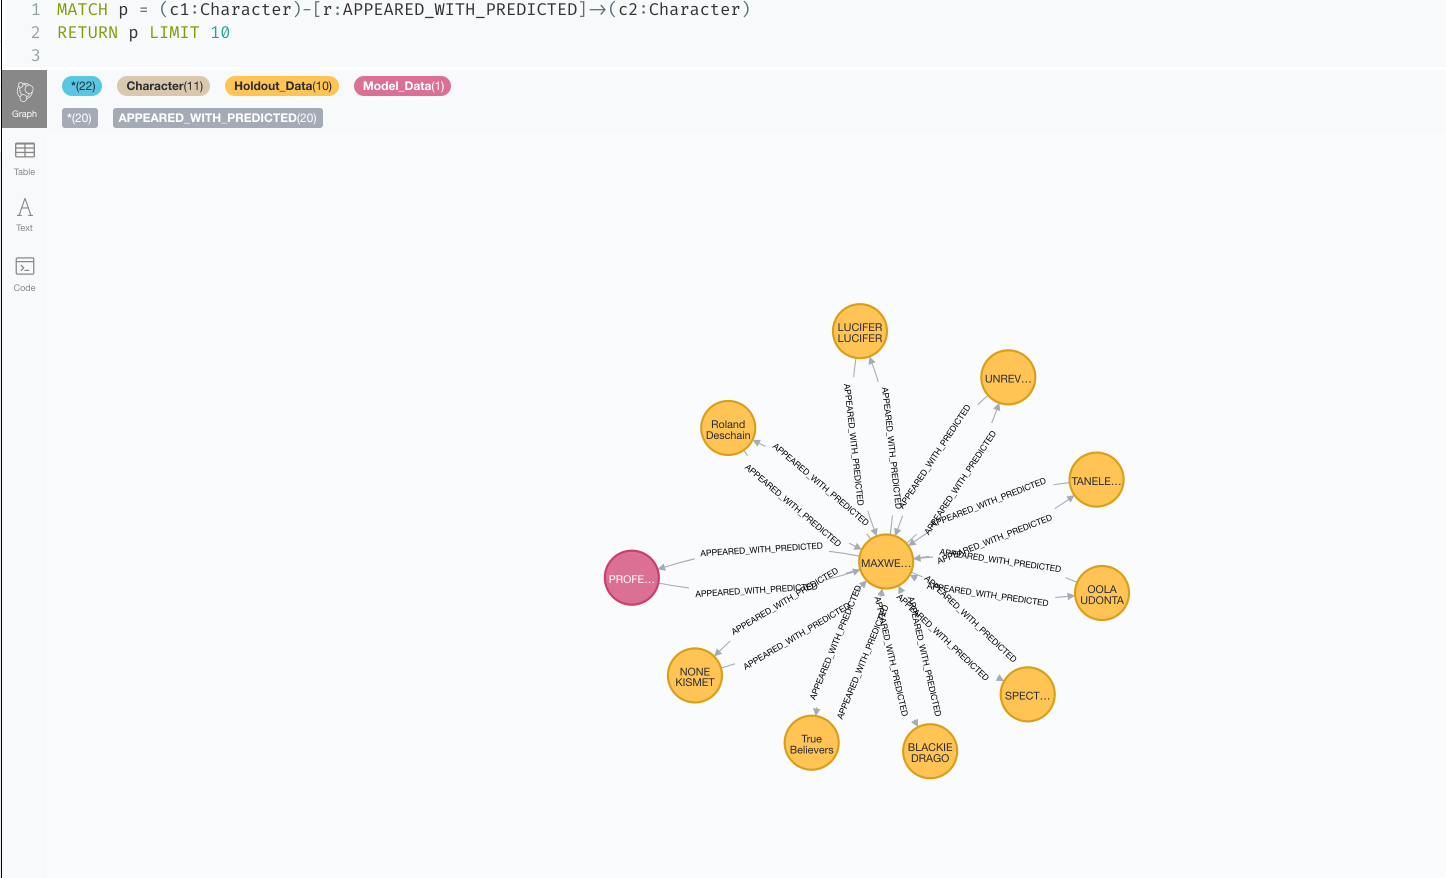